**Chapter 5 – Support Vector Machines**

_This notebook contains all the sample code and solutions to the exercices in chapter 5._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [9]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Large margin classification

In [10]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

We create some models by hand, choosing two lines that separate the blue squares from the
green circles in the left plot, and one that does not.

In the right plot we choose a different separator line.  This one is chosen to so as to maximize
the distance between the line and the nearest data points of each class.  Thus there is a **margin**
between the decision line (solid) and parallel lines passing through the nearest data points (dashed).

Saving figure large_margin_classification_plot


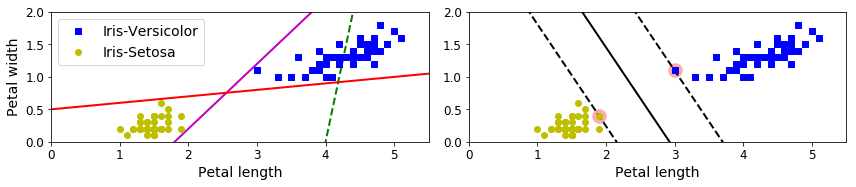

In [11]:
# Bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    global margin
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    margin2 = svm_clf.predict
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

plt.figure(figsize=(12,2.7))

plt.subplot(121)
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.subplot(122)
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

save_fig("large_margin_classification_plot")
plt.show()

# Sensitivity to feature scales

We cook up some data.  Note that the training data 
`X` consists of 4 points in 2D space.  Note also that the 
Col1 numbers are much smaller  than the Col2 numbers.

```
  |Col1 Col2
==|===========
A | 1    50
B | 5    20
C | 3    80
D | 5    60
```

This is a problem for training an SVM classifier.  They are notoriously sensitive to features
that use different scales.  The toy examples illustrates the problem.  

In the plot on the left, it appears that the blue point above the margin is a slam dunk,
well above the margin, clearly in the blue class.  In fact that is a consequence of the very different
scales of the two features.  If we use the `sklearn` `StandardScaler` to scale the feature values so that they fall on comparable scales, we see that from the point of the view of the scaled model, 
that point is quite close to the margin. 
Does that make a difference?  Yes, the two models will make different decisions on data
not seen during training.  The red diamond represents a single novel point not seen during either
training run, and the plots show how it is classified by the
unscaled and scaled models.  The unscaled model regards it a right on the positive margin and
therefore clearly in the positive class.  The scaled model places it clearly on the negative side
of the decision boundary, in the negative class.  The scaled model represents the new point
as more like the negative points, because it pays less attention to large differences in
the second feature.

Saving figure sensitivity_to_feature_scales_plot


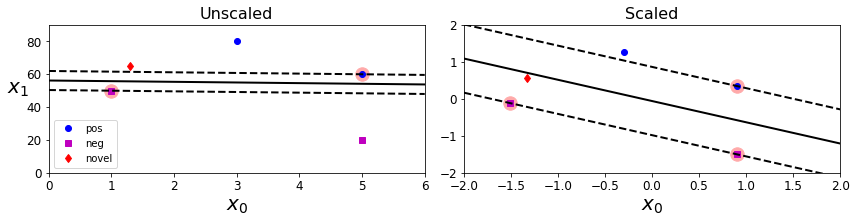

In [12]:
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(12,3.2))
plt.subplot(121)
#plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo", label='pos')
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms", label='neg')
# A novel point
ex = np.array([[1.3,65]])
plt.plot(ex[:,0], ex[:,1], "rd",label='novel')
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$  ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])
plt.legend()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)
#Scale the novel point
scaled_ex = scaler.transform(ex)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plt.plot(scaled_ex[:,0], scaled_ex[:,1], "rd")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x_0$", fontsize=20)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

save_fig("sensitivity_to_feature_scales_plot")

# Sensitivity to outliers

SVMs are sensitive to outliers.  In the data below we experiment with adding two different
outliers to the data.

The plot on the left shows that with the first point added, the data isn't linearly
separable at all.  No line can be drawn that separates the green circles from the blue squares.

The plot on the right shows what happens when the model is trained
with a different outlier, one that still makes the data linearly separable.
We see that even if a model is possible, a single point can have a huge effect
on where the margins and the decision boundary are placed.  What was a fairly
large margin model before has become a model with a very narrow margin, meaning
that points  like the outlier -- closer to the center of mass of the blue points than to the center
of mass of green points -- may well be classified as green.

Saving figure sensitivity_to_outliers_plot


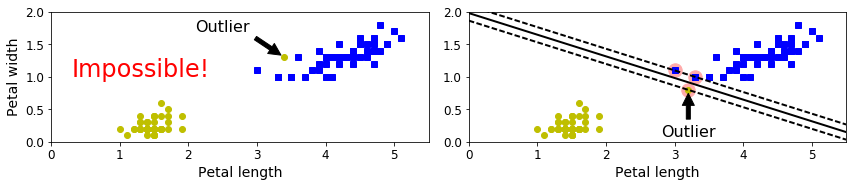

In [27]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)#float("inf")
#trainingX,trainingy,outliers_index = Xo1,yo1,0
trainingX,trainingy,outliers_index = Xo2,yo2,1
svm_clf2.fit(trainingX, trainingy)

plt.figure(figsize=(12,2.7))

plt.subplot(121)
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.subplot(122)
#outliers_index = 1
plt.plot(trainingX[:, 0][trainingy==1], trainingX[:, 1][trainingy==1], "bs")
plt.plot(trainingX[:, 0][trainingy==0], trainingX[:, 1][trainingy==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[outliers_index][0], X_outliers[outliers_index][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

save_fig("sensitivity_to_outliers_plot")
plt.show()

The next plot shows the basic solution to this problem, implemented
as the `C` parameter.  The `C` parameter controls the "slackness" or "tolerance" of the models
fit, how willing it is to forgive points that fall on the wrong side of the margin
or boundary, if that forgiveness can be traded in for a larger margin for the great
majority of the training points.  The same data and outlier is used as in the second
plot above, but the  `C` parameter is set to `1` instead of infinity, meaning that
outliers are tolerated in searching for a separating line.  We get a model in which
the outlier falls on the wrong side of the decision boundary, in return for a much greater
margin of separation for most of the points.

The payoff for this strategy will of course be seen with points unseen during training.
Will this greater margin gerealize better to unseen points and improve classification accuracy?

1.0 5.1
Saving figure sensitivity_to_outliers_plot2


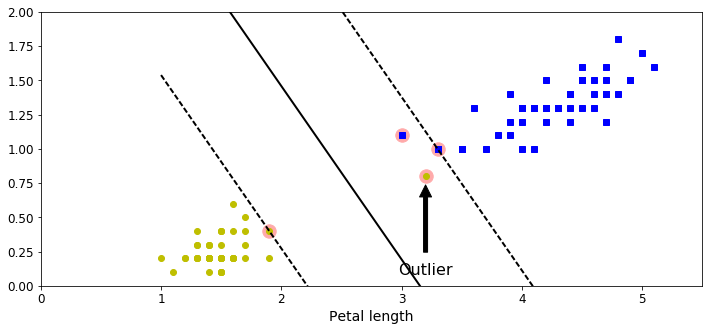

In [37]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=1.0)#float("inf")
#trainingX,trainingy,outliers_index = Xo1,yo1,0
trainingX,trainingy,outliers_index = Xo2,yo2,1
svm_clf2.fit(trainingX, trainingy)

plt.figure(figsize=(10,4.7))

plt.axis([0, 5.5, 0, 2])

#xmin,xmax = 0,5.5
xmin,xmax = trainingX[:, 0].min(),trainingX[:, 0].max()
print((xmin, xmax))
plt.subplot(111)
#outliers_index = 1
plt.plot(trainingX[:, 0][trainingy==1], trainingX[:, 1][trainingy==1], "bs")
plt.plot(trainingX[:, 0][trainingy==0], trainingX[:, 1][trainingy==0], "yo")
plot_svc_decision_boundary(svm_clf2, xmin, xmax)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[outliers_index][0], X_outliers[outliers_index][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

save_fig("sensitivity_to_outliers_plot2")
plt.show()

And here is what happens when the other outliers added, the one that
makes the data not linearly separable.

1.0 5.1
Saving figure sensitivity_to_outliers_plot3


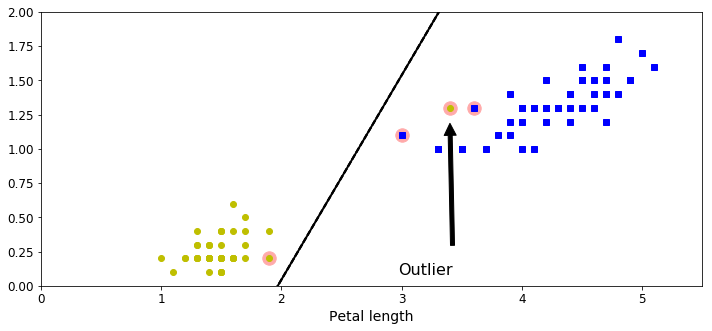

In [41]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)#float("inf")
trainingX,trainingy,outliers_index = Xo1,yo1,0
#trainingX,trainingy,outliers_index = Xo2,yo2,1
svm_clf2.fit(trainingX, trainingy)

plt.figure(figsize=(10,4.7))
plt.axis([0, 5.5, 0, 2])

#xmin,xmax = 0,5.5
xmin,xmax = trainingX[:, 0].min(),trainingX[:, 0].max()
print((xmin,xmax))
plt.subplot(111)
plt.plot(trainingX[:, 0][trainingy==1], trainingX[:, 1][trainingy==1], "bs")
plt.plot(trainingX[:, 0][trainingy==0], trainingX[:, 1][trainingy==0], "yo")
plot_svc_decision_boundary(svm_clf2, xmin, xmax)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[outliers_index][0], X_outliers[outliers_index][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

save_fig("sensitivity_to_outliers_plot3")
plt.show()

In [9]:
dir(svm_clf)

['C',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__getstate__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_check_proba',
 '_compute_kernel',
 '_decision_function',
 '_dense_decision_function',
 '_dense_fit',
 '_dense_predict',
 '_dense_predict_proba',
 '_dual_coef_',
 '_estimator_type',
 '_gamma',
 '_get_coef',
 '_get_param_names',
 '_impl',
 '_intercept_',
 '_pairwise',
 '_predict_log_proba',
 '_predict_proba',
 '_sparse',
 '_sparse_decision_function',
 '_sparse_fit',
 '_sparse_kernels',
 '_sparse_predict',
 '_sparse_predict_proba',
 '_validate_for_predict',
 '_validate_targets',
 '_warn_from_fit_status',
 'cache_size',
 'class_weight',
 'class_weight_',
 'classes_',
 'co

# Large margin *vs* margin violations

The next plot shows a more serious expeirment with the `C` parameter, comparing the effect of
setting `C` to `1` with setting `C` to `100`.

In [6]:
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris-Virginica

scaler = StandardScaler()
svm_clf1 = LinearSVC(C=100, loss="hinge")
svm_clf2 = LinearSVC(C=1, loss="hinge")

scaled_svm_clf1 = Pipeline((
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ))
scaled_svm_clf2 = Pipeline((
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ))

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

scaled_svm_clf2.predict([[5.5, 1.7]])

array([ 1.])

In [7]:
# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

Saving figure regularization_plot


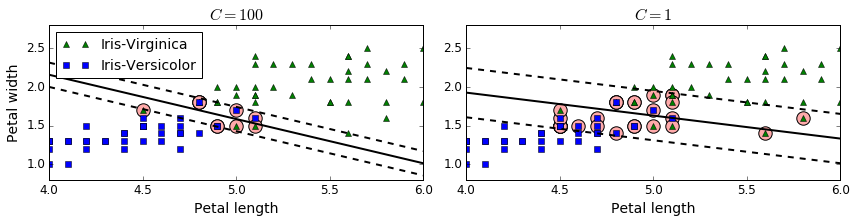

In [8]:
plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris-Versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

plt.subplot(122)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

save_fig("regularization_plot")

# Non-linear classification

Saving figure higher_dimensions_plot


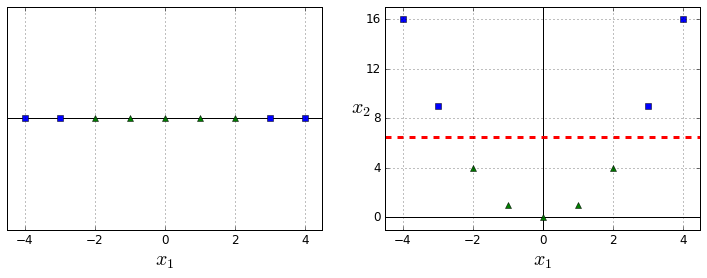

In [9]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

save_fig("higher_dimensions_plot", tight_layout=False)
plt.show()

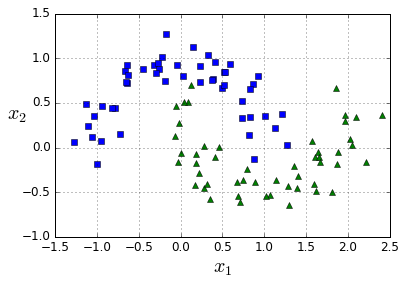

In [10]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

Saving figure moons_polynomial_svc_plot


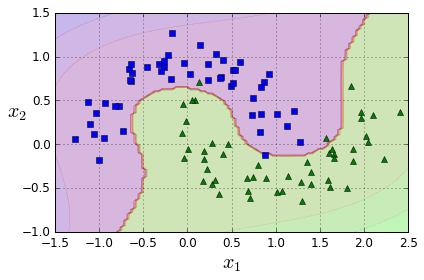

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline((
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge"))
    ))

polynomial_svm_clf.fit(X, y)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

Saving figure moons_kernelized_polynomial_svc_plot


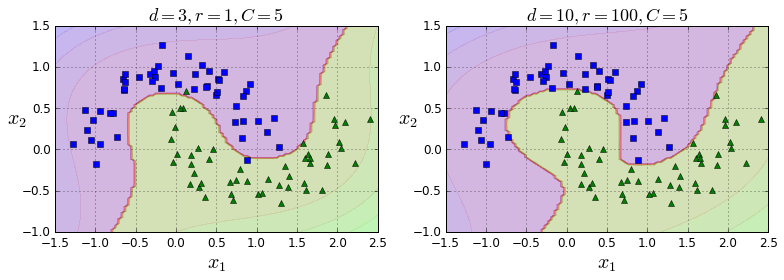

In [12]:
from sklearn.svm import SVC
poly_kernel_svm_clf = Pipeline((
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ))
poly100_kernel_svm_clf = Pipeline((
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ))

poly_kernel_svm_clf.fit(X, y)
poly100_kernel_svm_clf.fit(X, y)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.subplot(122)
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

Saving figure kernel_method_plot


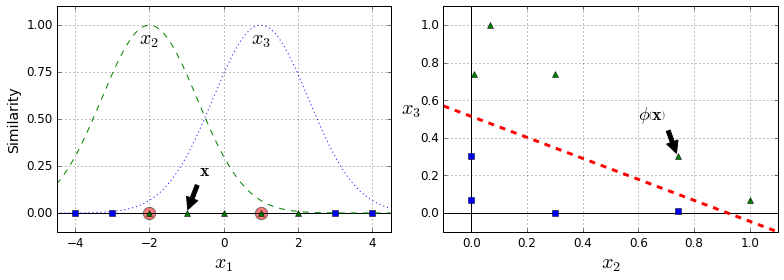

In [13]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()

In [14]:
x1_example = X1D[3, 0]
for landmark in (-2, 1):
    k = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print(("Phi({}, {}) = {}".format(x1_example, landmark, k)))

Phi(-1.0, -2) = [ 0.74081822]
Phi(-1.0, 1) = [ 0.30119421]


In [15]:
rbf_kernel_svm_clf = Pipeline((
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ))
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=(('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))))

Saving figure moons_rbf_svc_plot


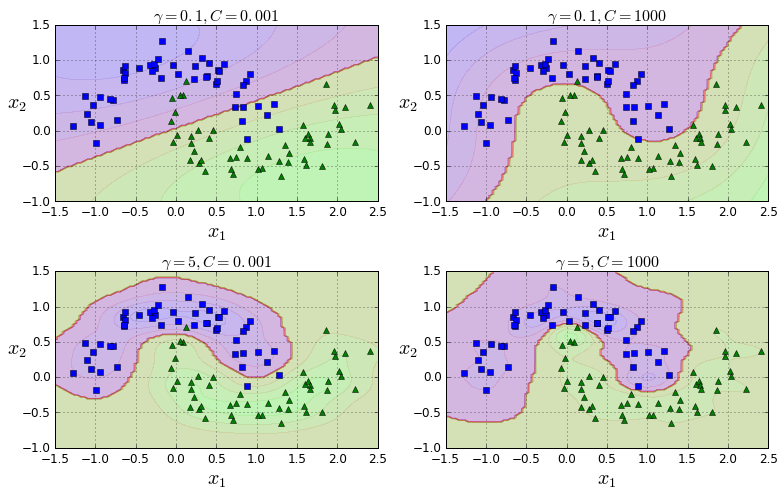

In [16]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline((
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ))
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

plt.figure(figsize=(11, 7))

for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221 + i)
    plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)

save_fig("moons_rbf_svc_plot")
plt.show()

# Regression


In [17]:
from sklearn.svm import LinearSVR

rnd.seed(42)
m = 50
X = 2 * rnd.rand(m, 1)
y = (4 + 3 * X + rnd.randn(m, 1)).ravel()

svm_reg1 = LinearSVR(epsilon=1.5)
svm_reg2 = LinearSVR(epsilon=0.5)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

Saving figure svm_regression_plot


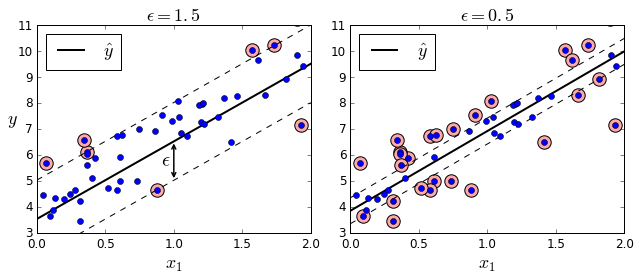

In [18]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.subplot(122)
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
save_fig("svm_regression_plot")
plt.show()

In [19]:
from sklearn.svm import SVR

rnd.seed(42)
m = 100
X = 2 * rnd.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + rnd.randn(m, 1)/10).ravel()

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1)
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='auto',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Saving figure svm_with_polynomial_kernel_plot


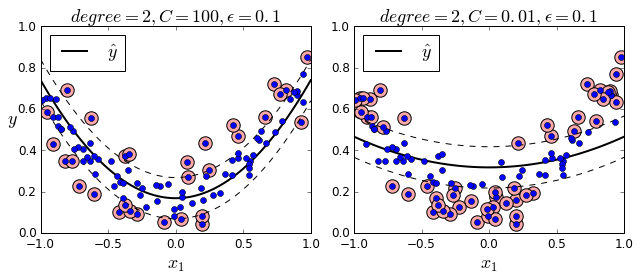

In [20]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.subplot(122)
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
save_fig("svm_with_polynomial_kernel_plot")
plt.show()

# Under the hood

In [21]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris-Virginica

Saving figure iris_3D_plot


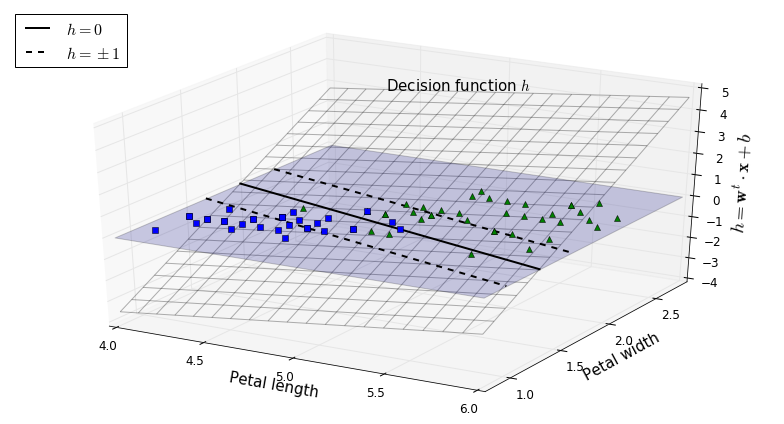

In [22]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, 0, color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=15)
    ax.set_xlabel(r"Petal length", fontsize=15)
    ax.set_ylabel(r"Petal width", fontsize=15)
    ax.set_zlabel(r"$h = \mathbf{w}^t \cdot \mathbf{x} + b$", fontsize=18)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax1, w=svm_clf2.coef_[0], b=svm_clf2.intercept_[0])

save_fig("iris_3D_plot")
plt.show()

# Small weight vector results in a large margin

Saving figure small_w_large_margin_plot


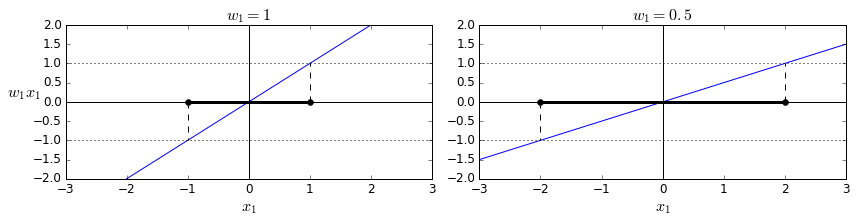

In [23]:
def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    m = 1 / w

    plt.plot(x1, y)
    plt.plot(x1_lim, [1, 1], "k:")
    plt.plot(x1_lim, [-1, -1], "k:")
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot([m, m], [0, 1], "k--")
    plt.plot([-m, -m], [0, -1], "k--")
    plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel(r"$x_1$", fontsize=16)
    if ylabel:
        plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
    plt.title(r"$w_1 = {}$".format(w), fontsize=16)

plt.figure(figsize=(12, 3.2))
plt.subplot(121)
plot_2D_decision_function(1, 0)
plt.subplot(122)
plot_2D_decision_function(0.5, 0, ylabel=False)
save_fig("small_w_large_margin_plot")
plt.show()

In [24]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64) # Iris-Virginica

svm_clf = SVC(kernel="linear", C=1)
svm_clf.fit(X, y)
svm_clf.predict([[5.3, 1.3]])

array([ 1.])

# Hinge loss

Saving figure hinge_plot


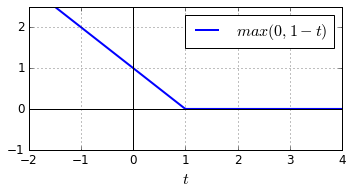

In [25]:
t = np.linspace(-2, 4, 200)
h = np.where(1 - t < 0, 0, 1 - t)  # max(0, 1-t)

plt.figure(figsize=(5,2.8))
plt.plot(t, h, "b-", linewidth=2, label="$max(0, 1 - t)$")
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.yticks(np.arange(-1, 2.5, 1))
plt.xlabel("$t$", fontsize=16)
plt.axis([-2, 4, -1, 2.5])
plt.legend(loc="upper right", fontsize=16)
save_fig("hinge_plot")
plt.show()

# Extra material

## Training time

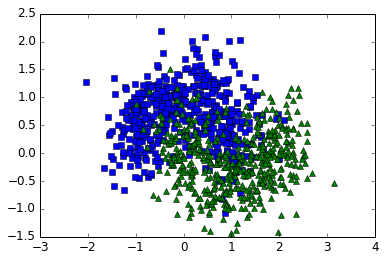

In [26]:
X, y = make_moons(n_samples=1000, noise=0.4)
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")

[LibSVM]0 0.1 0.3393280506134033
[LibSVM]1 0.01 0.32468748092651367
[LibSVM]2 0.001 0.3519587516784668
[LibSVM]3 0.0001 0.43623971939086914
[LibSVM]4 1e-05 0.39782047271728516
[LibSVM]5 1.0000000000000002e-06 0.38649845123291016
[LibSVM]6 1.0000000000000002e-07 0.3472158908843994
[LibSVM]7 1.0000000000000002e-08 0.3690824508666992
[LibSVM]8 1.0000000000000003e-09 0.3753695487976074
[LibSVM]9 1.0000000000000003e-10 0.3538534641265869


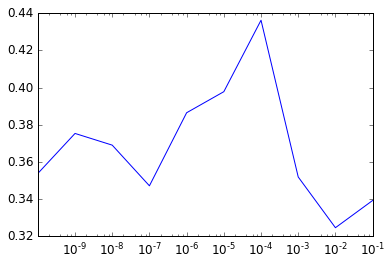

In [27]:
import time

tol = 0.1
tols = []
times = []
for i in range(10):
    svm_clf = SVC(kernel="poly", gamma=3, C=10, tol=tol, verbose=1)
    t1 = time.time()
    svm_clf.fit(X, y)
    t2 = time.time()
    times.append(t2-t1)
    tols.append(tol)
    print((i, tol, t2-t1))
    tol /= 10
plt.semilogx(tols, times)

## Identical linear classifiers

In [28]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

C = 5
alpha = 1 / (C * len(X))

sgd_clf = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=alpha, n_iter=100000, random_state=42)
svm_clf = SVC(kernel="linear", C=C)
lin_clf = LinearSVC(loss="hinge", C=C)

X_scaled = StandardScaler().fit_transform(X)
sgd_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
lin_clf.fit(X_scaled, y)

print(("SGDClassifier(alpha={}):     ".format(sgd_clf.alpha), sgd_clf.intercept_, sgd_clf.coef_))
print(("SVC:                         ", svm_clf.intercept_, svm_clf.coef_))
print(("LinearSVC:                   ", lin_clf.intercept_, lin_clf.coef_))

SGDClassifier(alpha=0.002):      [ 0.044] [[ 0.79840906 -1.48586286]]
SVC:                          [ 0.04569242] [[ 0.79788013 -1.48716383]]
LinearSVC:                    [ 0.04556425] [[ 0.79764006 -1.48669374]]


## Linear SVM classifier implementation using Batch Gradient Descent

In [29]:
# Training set
X = iris["data"][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64).reshape(-1, 1) # Iris-Virginica

In [30]:
from sklearn.base import BaseEstimator

class MyLinearSVC(BaseEstimator):
    def __init__(self, C=1, eta0=1, eta_d=10000, n_epochs=1000, random_state=None):
        self.C = C
        self.eta0 = eta0
        self.n_epochs = n_epochs
        self.random_state = random_state
        self.eta_d = eta_d

    def eta(self, epoch):
        return self.eta0 / (epoch + self.eta_d)
        
    def fit(self, X, y):
        # Random initialization
        if self.random_state:
            rnd.seed(self.random_state)
        w = rnd.randn(X.shape[1], 1) # n feature weights
        b = 0

        m = len(X)
        t = y * 2 - 1  # -1 if t==0, +1 if t==1
        X_t = X * t
        self.Js=[]

        # Training
        for epoch in range(self.n_epochs):
            support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
            X_t_sv = X_t[support_vectors_idx]
            t_sv = t[support_vectors_idx]

            J = 1/2 * np.sum(w * w) + self.C * (np.sum(1 - X_t_sv.dot(w)) - b * np.sum(t_sv))
            self.Js.append(J)

            w_gradient_vector = w - self.C * np.sum(X_t_sv, axis=0).reshape(-1, 1)
            b_derivative = -C * np.sum(t_sv)
                
            w = w - self.eta(epoch) * w_gradient_vector
            b = b - self.eta(epoch) * b_derivative
            

        self.intercept_ = np.array([b])
        self.coef_ = np.array([w])
        support_vectors_idx = (X_t.dot(w) + b < 1).ravel()
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        return X.dot(self.coef_[0]) + self.intercept_[0]

    def predict(self, X):
        return (self.decision_function(X) >= 0).astype(np.float64)

C=2
svm_clf = MyLinearSVC(C=C, eta0 = 10, eta_d = 1000, n_epochs=60000, random_state=2)
svm_clf.fit(X, y)
svm_clf.predict(np.array([[5, 2], [4, 1]]))

array([[ 1.],
       [ 0.]])

[0, 60000, 0, 100]

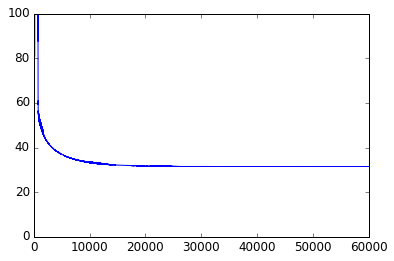

In [31]:
plt.plot(list(range(svm_clf.n_epochs)), svm_clf.Js)
plt.axis([0, svm_clf.n_epochs, 0, 100])

In [32]:
print((svm_clf.intercept_, svm_clf.coef_))

[-15.56780998] [[[ 2.28129013]
  [ 2.71597487]]]


In [33]:
svm_clf2 = SVC(kernel="linear", C=C)
svm_clf2.fit(X, y.ravel())
print((svm_clf2.intercept_, svm_clf2.coef_))

[-15.51721253] [[ 2.27128546  2.71287145]]


[4, 6, 0.8, 2.8]

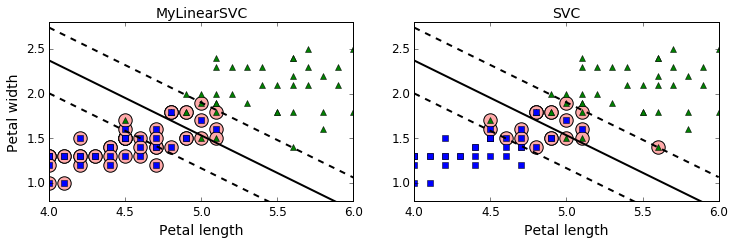

In [34]:
yr = y.ravel()
plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs", label="Not Iris-Virginica")
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("MyLinearSVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])

plt.subplot(122)
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("SVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])

[-14.062485     2.24179316   1.79750198]


[4, 6, 0.8, 2.8]

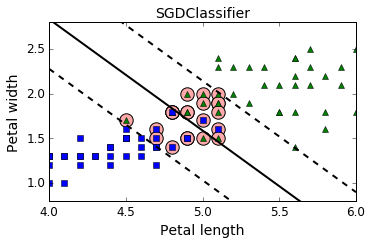

In [35]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="hinge", alpha = 0.017, n_iter = 50, random_state=42)
sgd_clf.fit(X, y.ravel())

m = len(X)
t = y * 2 - 1  # -1 if t==0, +1 if t==1
X_b = np.c_[np.ones((m, 1)), X]  # Add bias input x0=1
X_b_t = X_b * t
sgd_theta = np.r_[sgd_clf.intercept_[0], sgd_clf.coef_[0]]
print(sgd_theta)
support_vectors_idx = (X_b_t.dot(sgd_theta) < 1).ravel()
sgd_clf.support_vectors_ = X[support_vectors_idx]
sgd_clf.C = C

plt.figure(figsize=(5.5,3.2))
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(sgd_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("SGDClassifier", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])

# Exercise solutions

**Coming soon**